# 4. Which value chain portion contributes the most to CI variability across sectors? In other words: Determine which of the three value chain portions (upstream, operations, downstream) drives the largest differences in CI between sectors.

In [ ]:
import numpy as np
import pandas as pd

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

# Set display option to show all columns
pd.set_option('display.max_columns', None)

# Get rid of FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load the data

In [3]:
# Load the dataset
file_path = 'PublicTablesForCarbonCatalogueDataDescriptor_v30Oct2021.xlsx'
xls = pd.ExcelFile(file_path)

# Load each sheet
product_df = xls.parse('Product Level Data')
stage_df = xls.parse('Stage Level Data')

display(product_df.head())
display(stage_df.head())

,*PCF-ID,Year of reporting,*Stage-level CO2e available,Product name (and functional unit),Product detail,Company,Country (where company is incorporated),Company's GICS Industry Group,Company's GICS Industry,*Company's sector,Product weight (kg),*Source for product weight,"Product's carbon footprint (PCF, kg CO2e)",*Carbon intensity,Protocol used for PCF,Relative change in PCF vs previous,Company-reported reason for change,*Change reason category,*%Upstream estimated from %Operations,*Upstream CO2e (fraction of total PCF),*Operations CO2e (fraction of total PCF),*Downstream CO2e (fraction of total PCF),*Transport CO2e (fraction of total PCF),*EndOfLife CO2e (fraction of total PCF),*Adjustments to raw data (if any)
0,10056-1-2014,2014,Yes,Frosted Flakes(R) Cereal,"Frosted Flakes(R), 23 oz., Produced in Lancast...",Kellogg Company,USA,"Food, Beverage & Tobacco",Food Products,Food & Beverage,0.7485,Estimated from external data based on product ...,2.00,2.67,Not reported,(not reported by company),N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
1,10056-1-2015,2015,Yes,"Frosted Flakes, 23 oz, produced in Lancaster, ...",Cereal,Kellogg Company,USA,Food & Beverage Processing,Not used for 2015 reporting,Food & Beverage,0.7485,Estimated from external data based on product ...,2.00,2.67,Not reported,(not reported by company),N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
2,10222-1-2013,2013,Yes,Office Chair,Field not included in 2013 data,KNOLL INC,USA,Capital Goods,Building Products,Comm. equipm. & capital goods,20.6800,Estimated from external data based on product ...,72.54,3.51,Not reported,(not reported by company),N/a,N/a (no previous data available),Yes,0.8063,0.1736,0.0201,(included in up/downstream but not reported se...,0,"Changed %change to zero, according to field ""c..."
3,10261-1-2017,2017,Yes,Multifunction Printers,bizhub C458,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",110.0000,Estimated from external data based on product ...,1488.00,13.53,ISO,(not reported by company),N/a,N/a (no previous data available),No,0.3065,0.0551,0.6384,0.0101,0.0276,NaN
4,10261-2-2017,2017,Yes,Multifunction Printers,bizhub C558,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",110.0000,Estimated from external data based on product ...,1818.00,16.53,ISO,(not reported by company),N/a,N/a (no previous data available),No,0.2508,0.0451,0.7041,0.0083,0.0226,NaN


,*PCF-ID,Description of LCA stage,Scope-characterization of LCA stage,*Assigned value chain portion,Emissions at stage (kg CO2e),*Emissions at this stage are exclusively transport,*Emissions at this stage are exclusively EndOfLife
0,10056-1-2014,Other: Raw Material,Scope 3,Upstream,1.15,No,No
1,10056-1-2014,Manufacturing,Scope 1 & 2,Operations,0.60,No,No
2,10056-1-2014,Consumer use,Scope 3,Downstream,0.15,No,No
3,10056-1-2014,Transportation,Scope 3,Downstream,0.09,Yes,No
4,10056-1-2014,Storage,Scope 3,Downstream,0.01,No,No


In [20]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   *PCF-ID                                    866 non-null    object 
 1   Year of reporting                          866 non-null    int64  
 2   *Stage-level CO2e available                866 non-null    object 
 3   Product name (and functional unit)         866 non-null    object 
 4   Product detail                             856 non-null    object 
 5   Company                                    866 non-null    object 
 6   Country (where company is incorporated)    866 non-null    object 
 7   Company's GICS Industry Group              866 non-null    object 
 8   Company's GICS Industry                    866 non-null    object 
 9   *Company's sector                          866 non-null    object 
 10  Product weight (kg)       

In [17]:
stage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 7 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   *PCF-ID                                             1764 non-null   object 
 1   Description of LCA stage                            1764 non-null   object 
 2   Scope-characterization of LCA stage                 1764 non-null   object 
 3   *Assigned value chain portion                       1764 non-null   object 
 4   Emissions at stage (kg CO2e)                        1764 non-null   float64
 5   *Emissions at this stage are exclusively transport  1764 non-null   object 
 6   *Emissions at this stage are exclusively EndOfLife  1764 non-null   object 
dtypes: float64(1), object(6)
memory usage: 96.6+ KB


In [6]:
product_df.columns

Index(['*PCF-ID', 'Year of reporting', '*Stage-level CO2e available',
       'Product name (and functional unit)', 'Product detail', 'Company',
       'Country (where company is incorporated)',
       'Company's GICS Industry Group', 'Company's GICS Industry',
       '*Company's sector', 'Product weight (kg)',
       '*Source for product weight',
       'Product's carbon footprint (PCF, kg CO2e)', '*Carbon intensity',
       'Protocol used for PCF', 'Relative change in PCF vs previous',
       'Company-reported reason for change', '*Change reason category',
       '*%Upstream estimated from %Operations',
       '*Upstream CO2e (fraction of total PCF)',
       '*Operations CO2e (fraction of total PCF)',
       '*Downstream CO2e (fraction of total PCF)',
       '*Transport CO2e (fraction of total PCF)',
       '*EndOfLife CO2e (fraction of total PCF)',
       '*Adjustments to raw data (if any)'],
      dtype='object')

In [7]:
stage_df.columns

Index(['*PCF-ID', 'Description of LCA stage',
       'Scope-characterization of LCA stage', '*Assigned value chain portion',
       'Emissions at stage (kg CO2e)',
       '*Emissions at this stage are exclusively transport',
       '*Emissions at this stage are exclusively EndOfLife'],
      dtype='object')

In [32]:
# Убираем символ * из всех названий столбцов
product_df.columns = product_df.columns.str.replace('*', '', regex=False)
stage_df.columns = stage_df.columns.str.replace('*', '', regex=False)

## Analysis of Sector Groups
### 1. Check Similar Sample Size Across Sector Groups

In [36]:
# Check unique values in Company's sector
product_df['Company\'s sector'].value_counts()

Company's sector
Computer, IT & telecom                  253
Food & Beverage                         139
Home durables, textiles, & equipment    122
Chemicals                               116
Automobiles & components                 75
Construction & commercial materials      67
Comm. equipm. & capital goods            56
Packaging for consumer goods             38
Name: count, dtype: int64

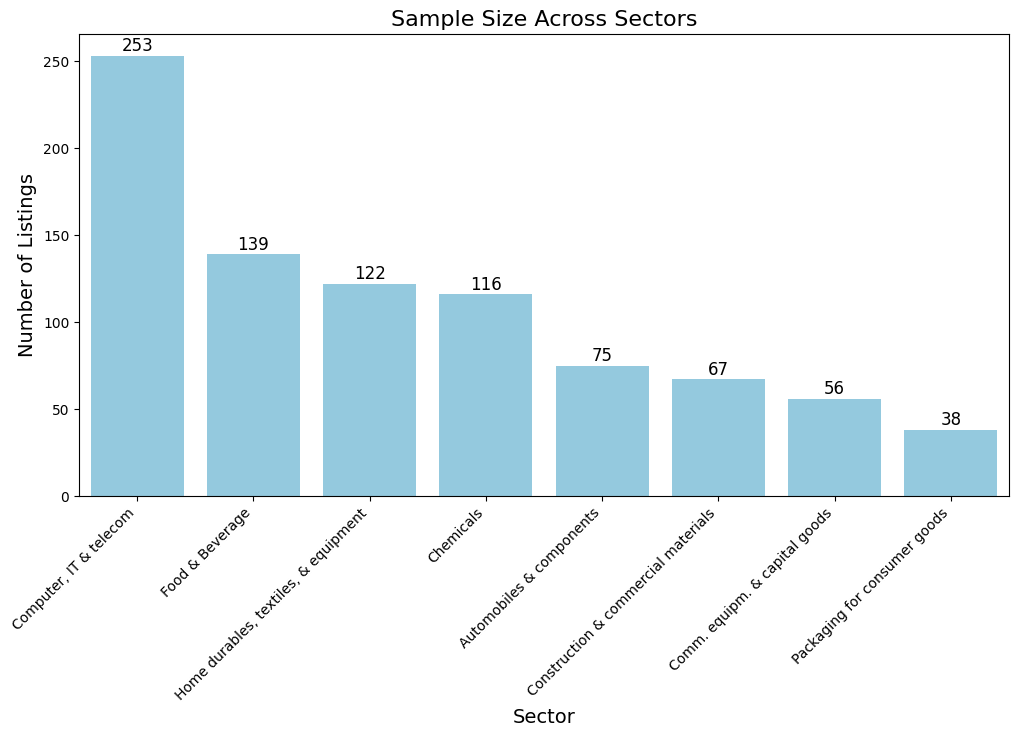

In [54]:
# Check the counts of each sector
sector_counts = product_df['Company\'s sector'].value_counts()

# Plot bar plot to check the sample size across sectors
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=sector_counts.index, y=sector_counts.values, color='skyblue')

# Add labels to each bar
for i, value in enumerate(sector_counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)

# Title and labels
plt.title("Sample Size Across Sectors", fontsize=16)
plt.xlabel("Sector", fontsize=14)
plt.ylabel("Number of Listings", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed

# Show the plot
plt.show()

**Conclusion:**
* The plot reveals that some sectors, such as “Computer, IT & telecom” have significantly larger sample sizes compared to others like “Packaging for consumer goods” and “Construction & commercial materials.” 
* This imbalance may impact the validity of ANOVA results, as unequal sample sizes can lead to biased or unreliable outcomes. To address this, we could focus on sectors with similar sample sizes or use alternative statistical methods suitable for unbalanced groups.

### 2. Similar variance across groups

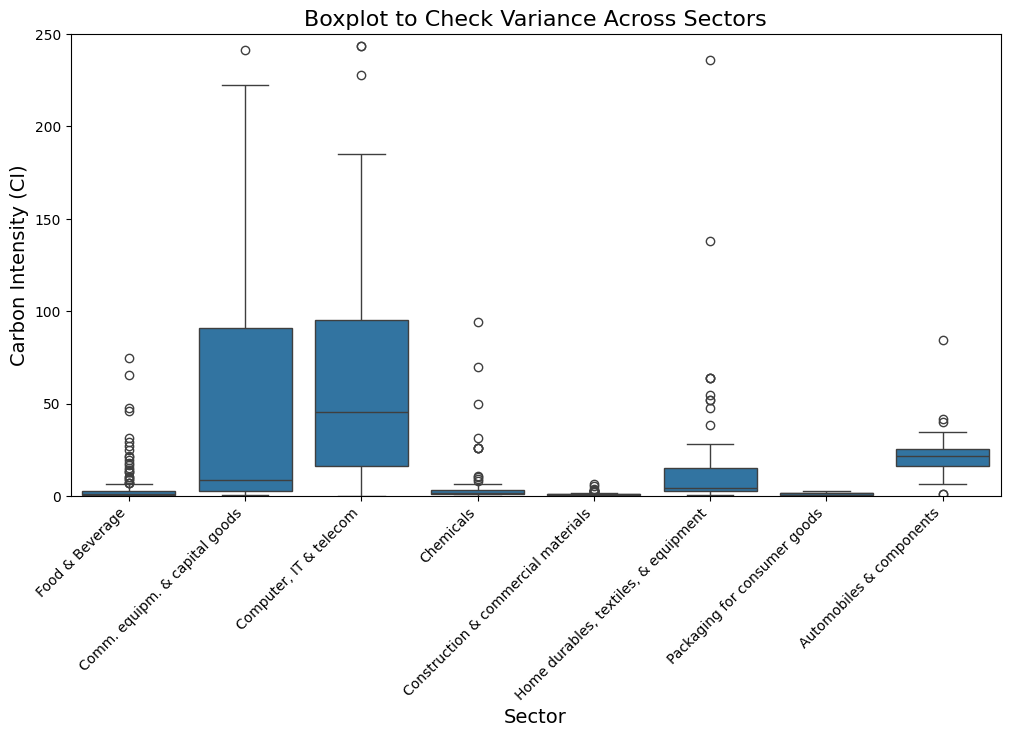

In [ ]:
# Create a boxplot to check the variance of CI values across sectors
plt.figure(figsize=(12, 6))
sns.boxplot(x='Company\'s sector', y='Carbon intensity', data=product_df)
plt.title('Boxplot to Check Variance Across Sectors', fontsize=16)
plt.xlabel('Sector', fontsize=14)
plt.ylabel('Carbon Intensity (CI)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Limit the y-axis to make the plot more readable
plt.ylim(0, 250)

plt.show()

**Conclusion:**
* The boxplot highlights that sectors with high variance, such as Computer, IT & telecom and Comm. equipment, may require further analysis to identify the causes of significant differences in carbon intensity. 
* Sectors with low variance, like Food & Beverage and Packaging, can serve as benchmarks for sustainable practices. 
* Outliers should also be examined, as they might indicate unique or problematic processes within certain companies.

### 3. Normality of the dependent variable (Carbon Intensity) for each sector group

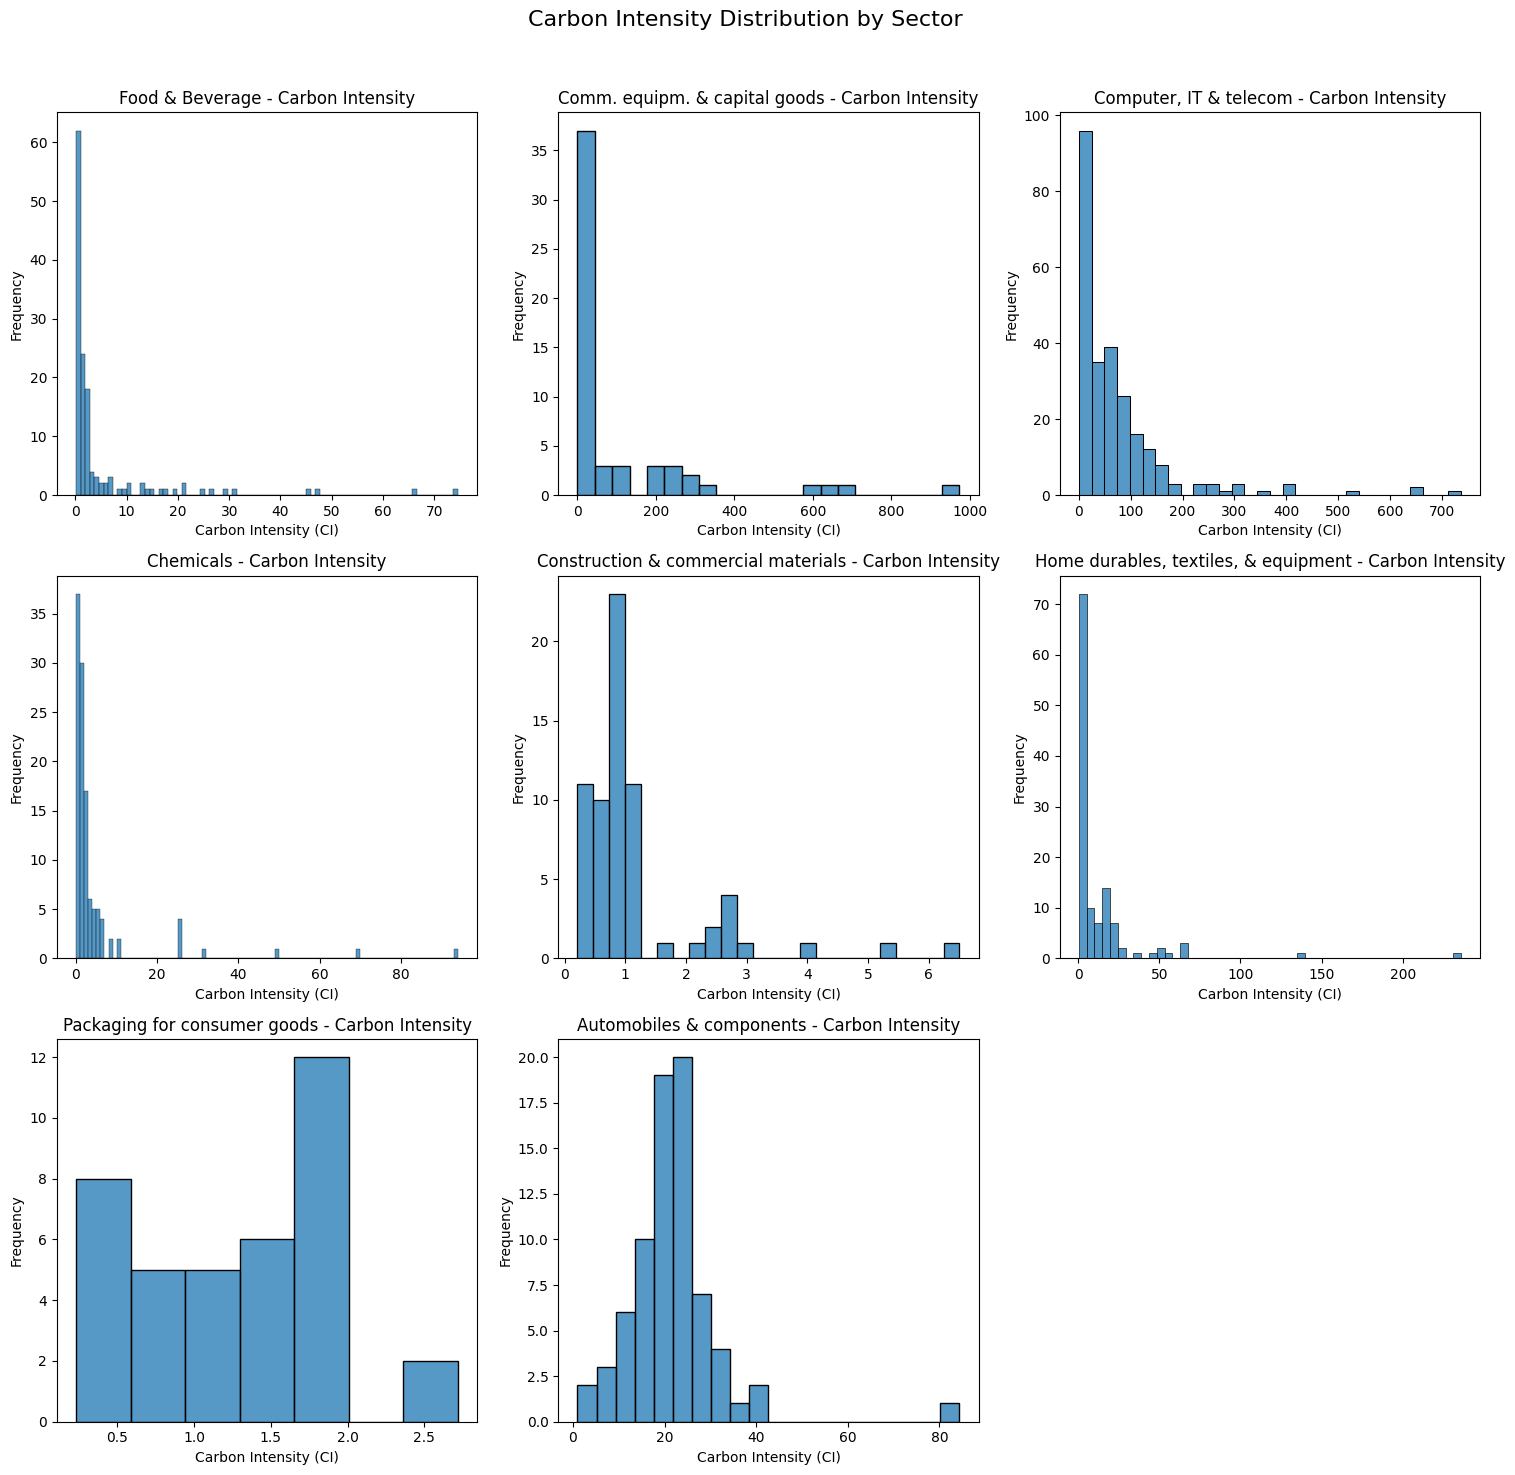

In [81]:
# Get unique sectors from product_df
sectors = product_df['Company\'s sector'].unique()

# Calculate the number of rows required for 3 columns per row
ncols = 3
nrows = int(np.ceil(len(sectors) / ncols))  # Round up to ensure we cover all sectors

# Create subplots with 3 columns per row
plt.figure(figsize=(15, 5 * nrows))

# Create the subplots
for i, sector in enumerate(sectors, 1):
    plt.subplot(nrows, ncols, i)  # Position the histograms (3 per row)
    sector_data = product_df[product_df['Company\'s sector'] == sector]
    sns.histplot(sector_data['Carbon intensity'])
    plt.title(f'{sector} - Carbon Intensity', fontsize=12)
    plt.xlabel('Carbon Intensity (CI)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

# Set the overall title
plt.suptitle('Carbon Intensity Distribution by Sector', fontsize=16)

# Adjust layout to ensure the title and plots don't overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

**Conclusion:**

The analysis reveals the following insights about Carbon Intensity (CI) across sectors:

1.	Sample Size Across Sectors: The number of listings varies significantly across sectors, with Computer, IT & Telecom having the largest sample size (253) and Packaging for consumer goods having the smallest (38).
2.	Variance Across Sectors: A boxplot comparison shows substantial variance in CI, especially for sectors like Food & Beverage, Computer, IT & Telecom, and Chemicals, which exhibit large outliers. This indicates a broad range of CI values within these sectors.
3.	Distribution Across Sectors: The histograms reveal that the CI distribution is highly skewed, particularly in sectors such as Food & Beverage and Chemicals, with many entries clustering around lower CI values.

The combination of sample size distribution, variance, and distribution analysis highlights that certain sectors show considerable variation in CI, suggesting the need for targeted interventions for those sectors with high variability.

## Analysis of how the three value chain portions (upstream, operations, downstream) drive the largest differences in CI between sectors

In [105]:
# Load the necessary columns from product_df
value_chain_columns = ['Company\'s sector', 'Upstream CO2e (fraction of total PCF)', 
                       'Operations CO2e (fraction of total PCF)', 'Downstream CO2e (fraction of total PCF)']

# Create a new DataFrame with relevant columns
value_chain_data = product_df[value_chain_columns]

# Ensure the value chain columns are numeric
value_chain_data.loc[:, 'Upstream CO2e (fraction of total PCF)'] = pd.to_numeric(value_chain_data['Upstream CO2e (fraction of total PCF)'], errors='coerce')
value_chain_data.loc[:, 'Operations CO2e (fraction of total PCF)'] = pd.to_numeric(value_chain_data['Operations CO2e (fraction of total PCF)'], errors='coerce')
value_chain_data.loc[:, 'Downstream CO2e (fraction of total PCF)'] = pd.to_numeric(value_chain_data['Downstream CO2e (fraction of total PCF)'], errors='coerce')

# Drop any rows with missing values in the value chain columns
value_chain_data = value_chain_data.dropna()

# Check for variability of CI across sectors by value chain portion
# Group by sector and calculate the variance of each value chain portion
sector_variability = value_chain_data.groupby('Company\'s sector').var()

# Round the values to 2 decimal places
sector_variability = sector_variability.round(2)

# Display the variability for each sector across the value chain portions
print("\033[1mCI Variability Across Sectors (Value Chain Portions):\033[0m")
display(sector_variability)

CI Variability Across Sectors (Value Chain Portions):


,Upstream CO2e (fraction of total PCF),Operations CO2e (fraction of total PCF),Downstream CO2e (fraction of total PCF)
Company's sector,,,
Automobiles & components,0.008066,0.000798,0.013889
Chemicals,0.10318,0.08523,0.063007
Comm. equipm. & capital goods,0.135633,0.017939,0.18364
"Computer, IT & telecom",0.110588,0.040652,0.109715
Construction & commercial materials,0.007742,0.009935,0.003474
Food & Beverage,0.030351,0.054487,0.030659
"Home durables, textiles, & equipment",0.05518,0.024422,0.072119
Packaging for consumer goods,0.002826,0.000547,0.003349


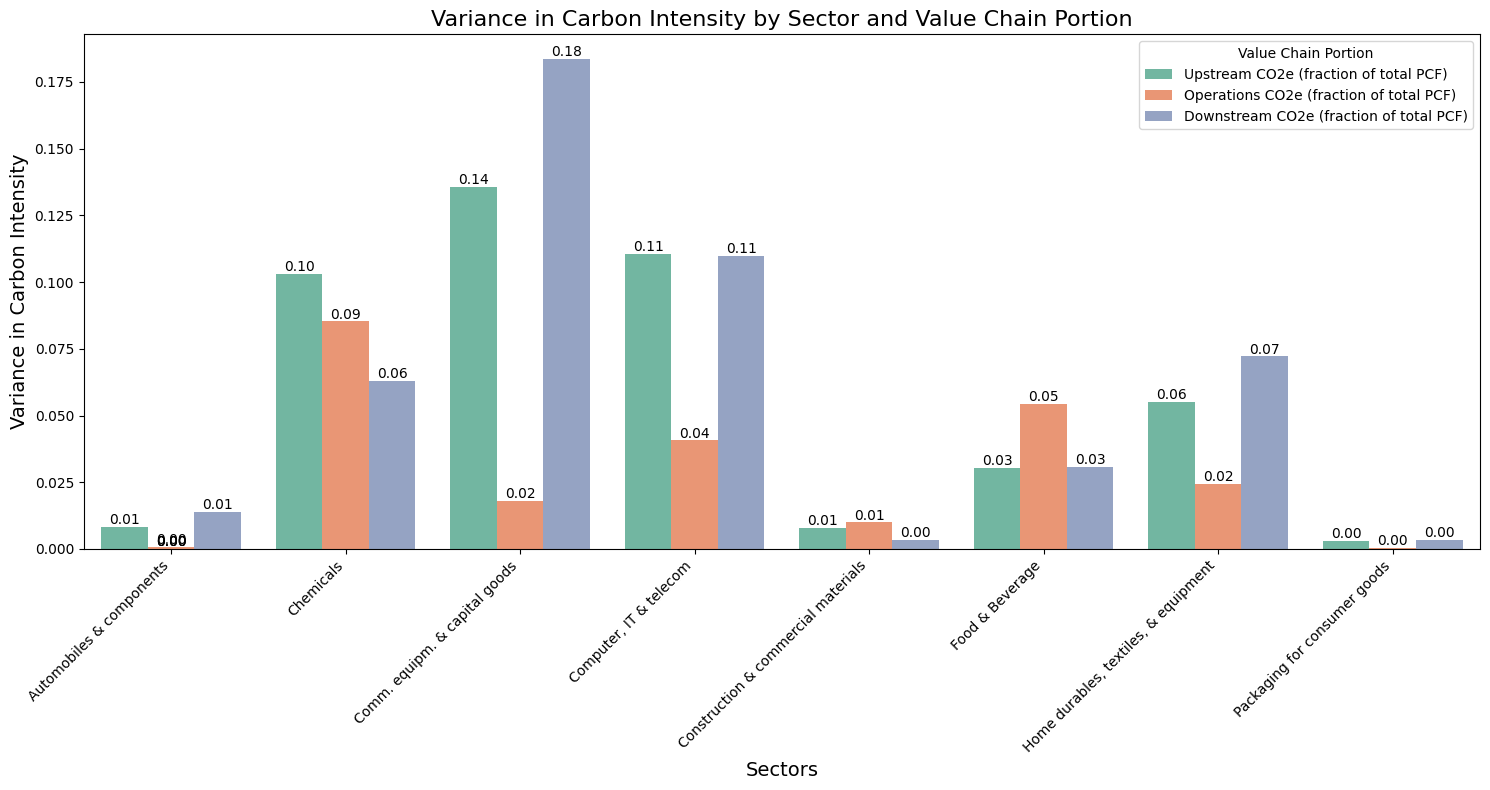

In [98]:
# Melt the sector_variability DataFrame to reshape it into a long format
melted_sector_variability = sector_variability.reset_index().melt(id_vars=["Company's sector"], 
                                                                  value_vars=["Upstream CO2e (fraction of total PCF)", 
                                                                              "Operations CO2e (fraction of total PCF)", 
                                                                              "Downstream CO2e (fraction of total PCF)"], 
                                                                  var_name="Value Chain Portion", 
                                                                  value_name="Variance")

# Create a bar plot with sectors on the x-axis and variance on the y-axis, with bars next to each other for each value chain portion
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=melted_sector_variability, x="Company's sector", y="Variance", hue="Value Chain Portion", 
                 dodge=True, palette="Set2")

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title('Variance in Carbon Intensity by Sector and Value Chain Portion', fontsize=16)
plt.xlabel('Sectors', fontsize=14)
plt.ylabel('Variance in Carbon Intensity', fontsize=14)

# Add the variance values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Conclusion:** Downstream Comm. equipment and capital goods has the highest variance.

F-statistic: 52.62736010468611, p-value: 1.1189760272665259e-22
There is a significant difference in CI variability between the value chain portions.

The value chain portion contributing the most to CI variability is: Upstream CO2e (fraction of total PCF) with variance: 0.4452448931116394


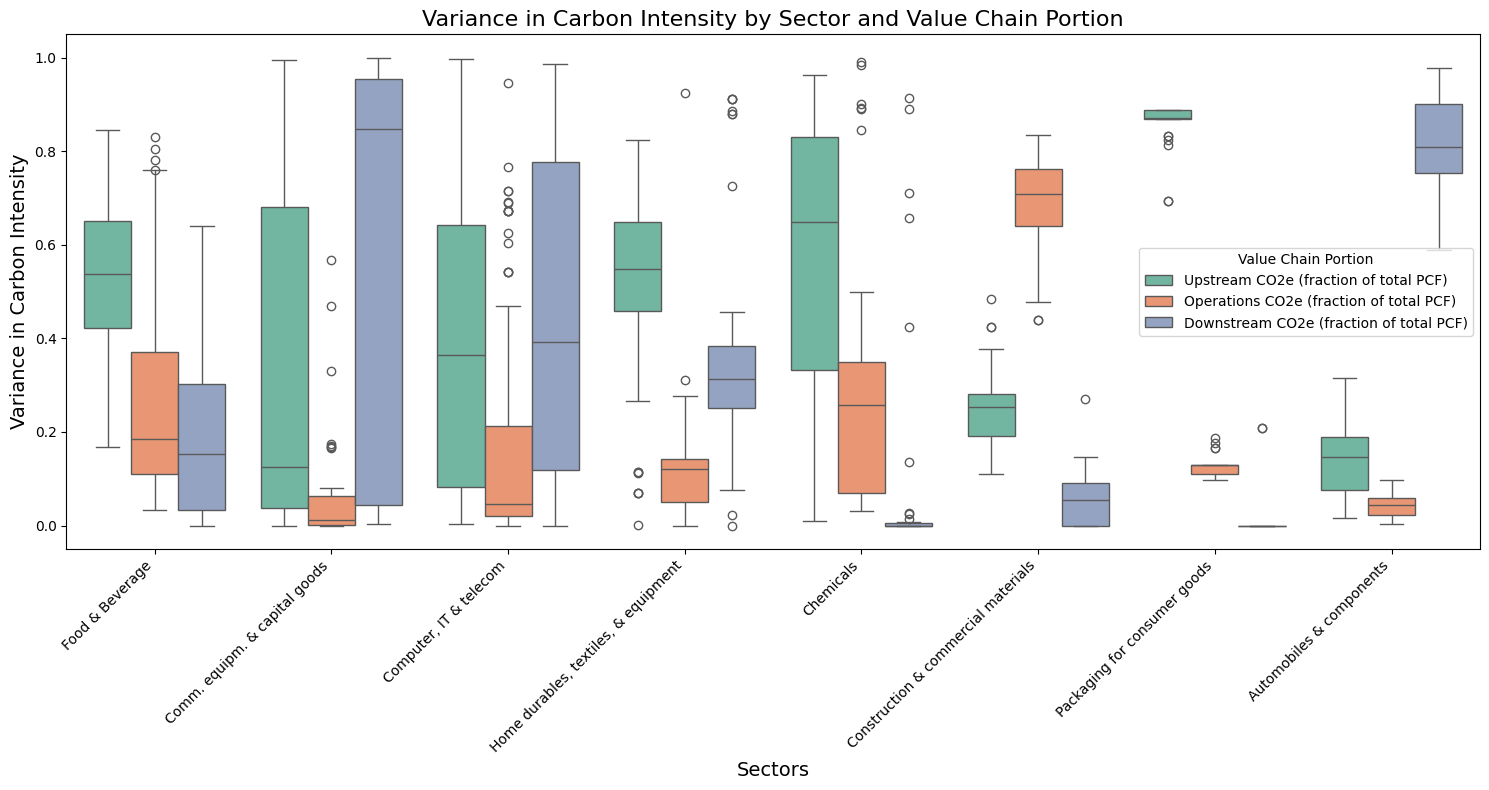

In [ ]:
# Melt the value_chain_data DataFrame into a long format
melted_value_chain_data = value_chain_data.reset_index().melt(id_vars=["Company's sector"], 
                                                              value_vars=["Upstream CO2e (fraction of total PCF)", 
                                                                          "Operations CO2e (fraction of total PCF)", 
                                                                          "Downstream CO2e (fraction of total PCF)"], 
                                                              var_name="Value Chain Portion", 
                                                              value_name="Variance")

# Perform one-way ANOVA to check for significant differences between value chain portions (upstream, operations, downstream)
f_stat, p_value = stats.f_oneway(
    melted_value_chain_data[melted_value_chain_data['Value Chain Portion'] == 'Upstream CO2e (fraction of total PCF)']['Variance'],
    melted_value_chain_data[melted_value_chain_data['Value Chain Portion'] == 'Operations CO2e (fraction of total PCF)']['Variance'],
    melted_value_chain_data[melted_value_chain_data['Value Chain Portion'] == 'Downstream CO2e (fraction of total PCF)']['Variance']
)

# Print the results of the ANOVA test
print(f"F-statistic: {f_stat}, p-value: {p_value}")

# Interpreting the results
if p_value < 0.05:
    print("There is a significant difference in CI variability between the value chain portions.")
else:
    print("There is no significant difference in CI variability between the value chain portions.")

# Identify which value chain portion has the highest variance
# Group the melted data by 'Value Chain Portion' and calculate the mean variance for each portion
variance_by_portion = melted_value_chain_data.groupby('Value Chain Portion')['Variance'].mean()

# Find the value chain portion with the highest variance
highest_variability_portion = variance_by_portion.idxmax()
highest_variability_value = variance_by_portion.max()

print(f"\nThe value chain portion contributing the most to CI variability is: {highest_variability_portion} with variance: {highest_variability_value}")

# Visualize the variance for each value chain portion (Upstream, Operations, Downstream) across sectors
plt.figure(figsize=(15, 8))
sns.boxplot(data=melted_value_chain_data, x="Company's sector", y="Variance", hue="Value Chain Portion", dodge=True, palette="Set2")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title('Variance in Carbon Intensity by Sector and Value Chain Portion', fontsize=16)
plt.xlabel('Sectors', fontsize=14)
plt.ylabel('Variance in Carbon Intensity', fontsize=14)

# Adjust layout to make sure labels fit
plt.tight_layout()

# Show the plot
plt.show()


**Conclusion:**

* The analysis of carbon intensity (CI) variability across sectors reveals that the Upstream CO2e (fraction of total PCF) portion contributes the most to CI variability, with the highest variance of 0.4452.
* This indicates that the upstream stage of the value chain (e.g., raw material extraction, production processes) has the greatest impact on the differences in CI across sectors.
* For example, sectors like Comm. equipment & capital goods, Chemicals, and Computer, IT, and Telecom show notably higher variability in this portion, while sectors like Packaging for consumer goods and Construction & commercial materials exhibit much smaller variability in their upstream CI.
* This insight suggests that focusing on reducing carbon emissions in the upstream value chain portion could lead to significant reductions in overall CI across various sectors.